Epoch 1/50: 100%|██████████| 782/782 [00:42<00:00, 18.30it/s, D_loss=0.705, G_loss=0.824]


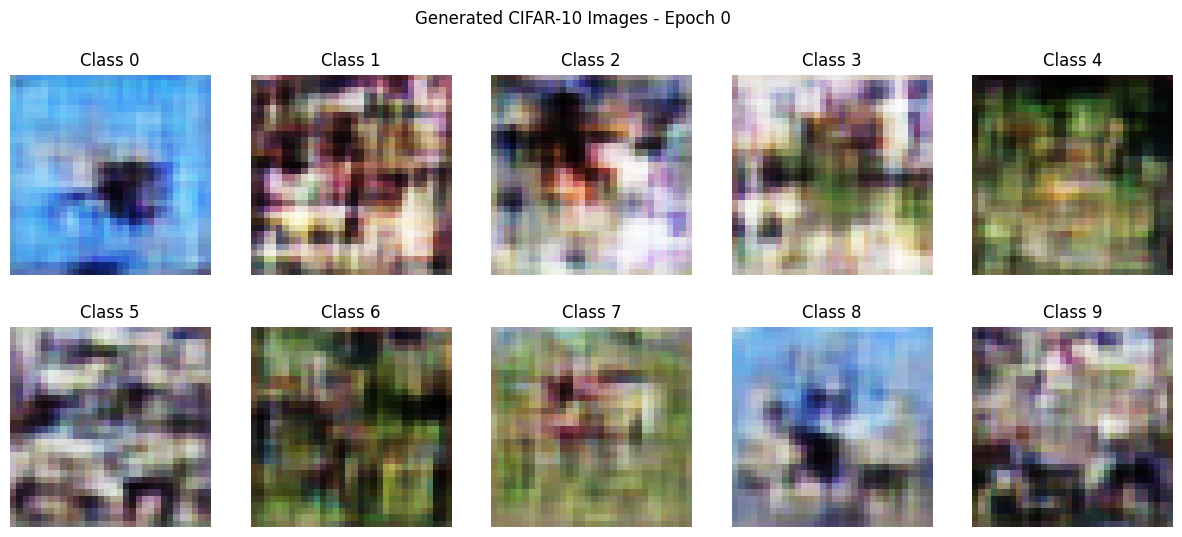

Epoch 11/50: 100%|██████████| 782/782 [00:43<00:00, 18.07it/s, D_loss=0.65, G_loss=2.44]


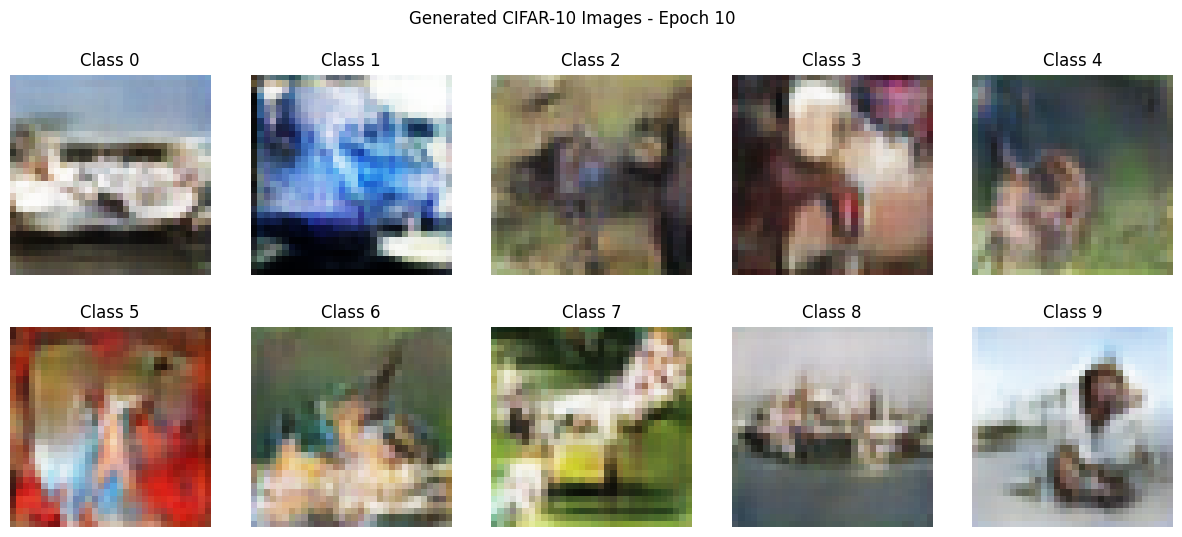

Epoch 21/50: 100%|██████████| 782/782 [00:43<00:00, 17.80it/s, D_loss=0.344, G_loss=3.7]


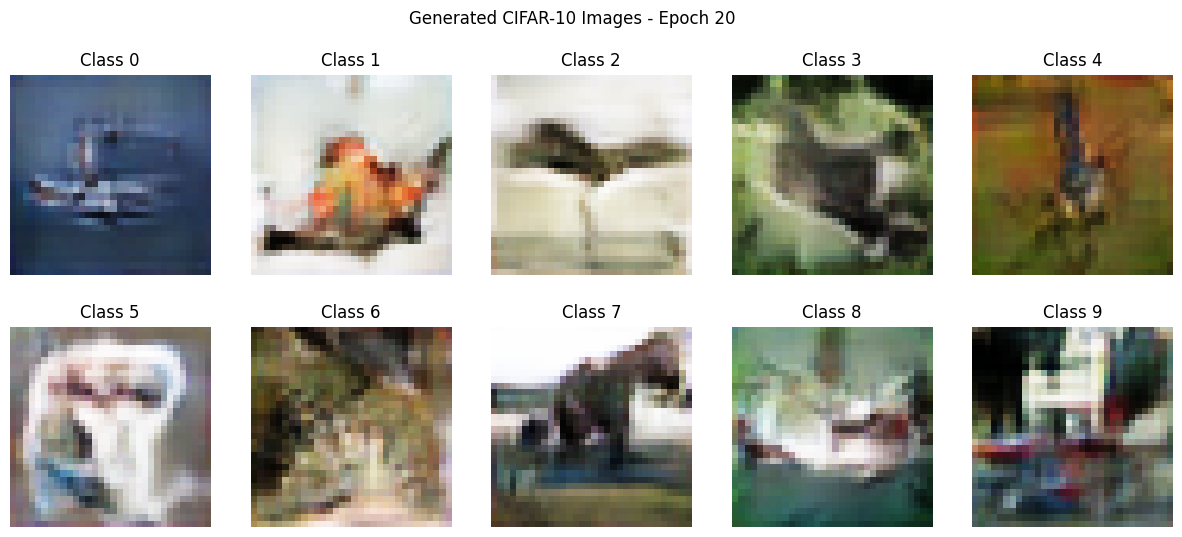

Epoch 31/50: 100%|██████████| 782/782 [00:44<00:00, 17.72it/s, D_loss=0.148, G_loss=4.78]


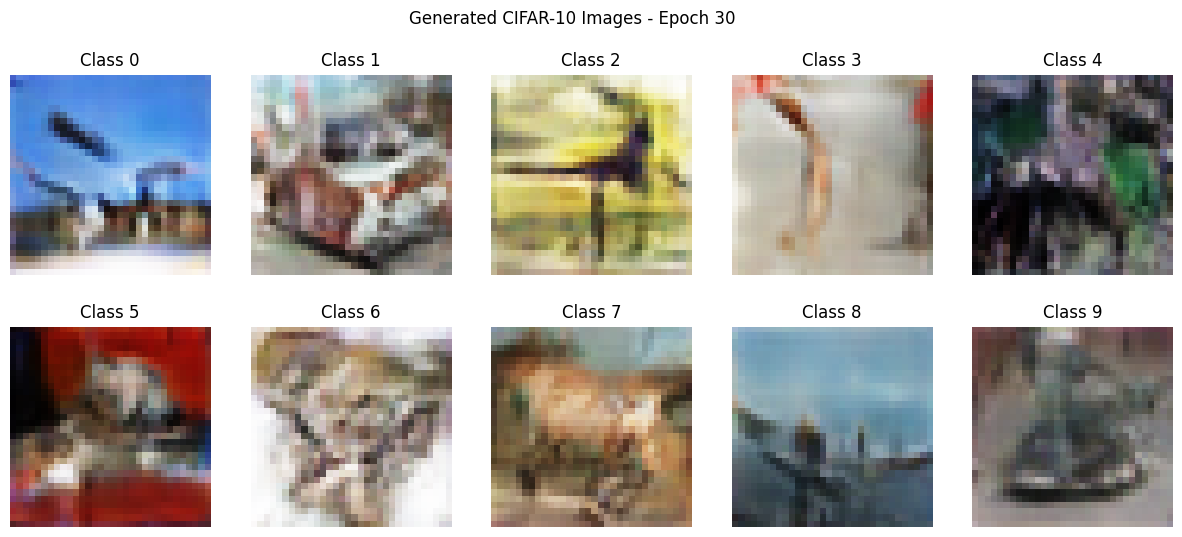

Epoch 41/50: 100%|██████████| 782/782 [00:44<00:00, 17.44it/s, D_loss=0.129, G_loss=5.21]


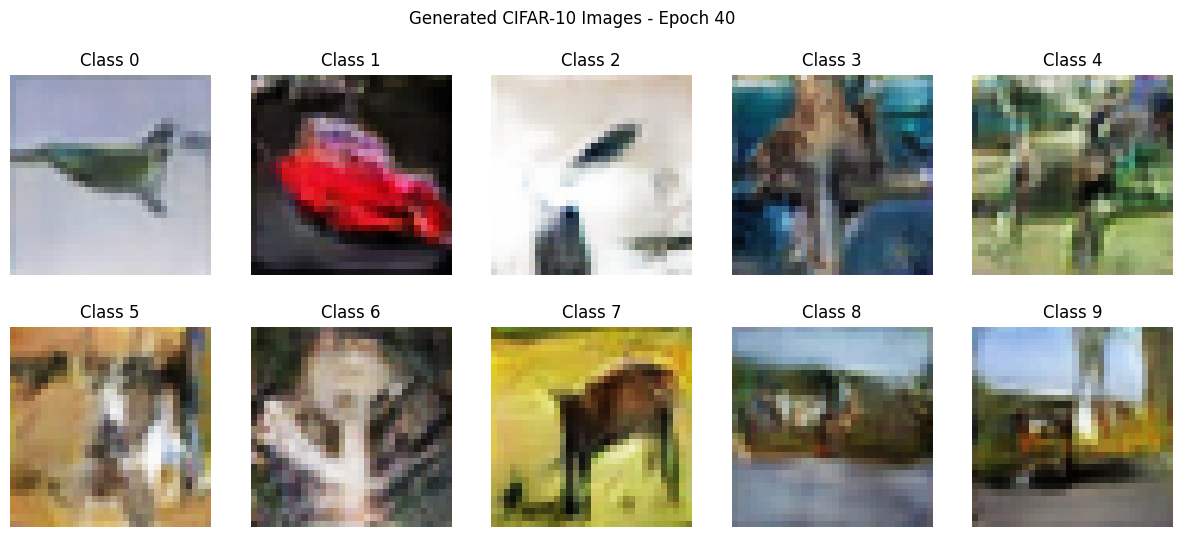

Epoch 50/50: 100%|██████████| 782/782 [00:44<00:00, 17.45it/s, D_loss=0.278, G_loss=9.28]


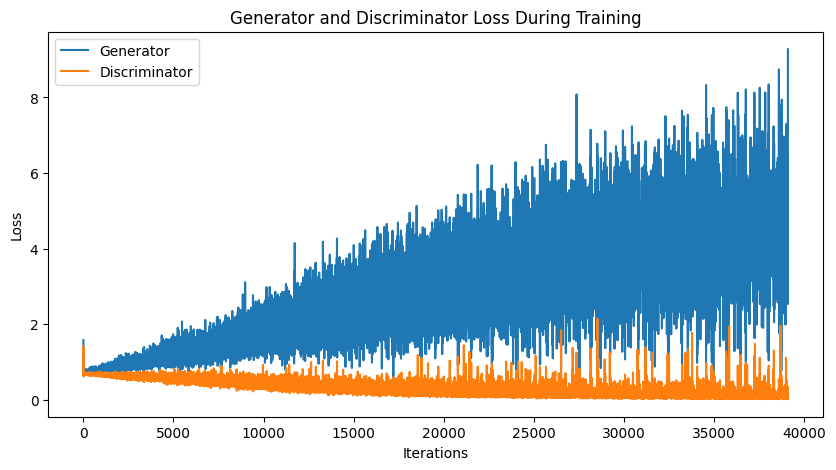

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
latent_dim = 100
num_classes = 10  # CIFAR-10 has 10 classes
img_size = 32
channels = 3
batch_size = 64
epochs = 50
lr = 0.0002
b1 = 0.5
b2 = 0.999

# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.init_size = img_size // 4  # Initial size before upsampling
        self.l1 = nn.Sequential(nn.Linear(latent_dim + num_classes, 128 * self.init_size**2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Label embedding - outputs 1 channel to match with RGB (3) + 1 = 4 channels
        self.label_embedding = nn.Embedding(num_classes, 1)

        # Input channels: 3 (RGB) + 1 (label channel) = 4
        self.main = nn.Sequential(
            # Input: 4 x 32 x 32
            nn.Conv2d(4, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # State: 64 x 16 x 16
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # State: 128 x 8 x 8
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # State: 256 x 4 x 4
            nn.Conv2d(256, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # Output: 1 x 1 x 1
            nn.Conv2d(512, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # Embed labels and reshape to match image dimensions
        label_emb = self.label_embedding(labels)  # [batch_size, 1]
        label_emb = label_emb.view(-1, 1, 1, 1)  # [batch_size, 1, 1, 1]
        label_emb = label_emb.expand(-1, 1, img.size(2), img.size(3))  # [batch_size, 1, 32, 32]

        # Concatenate image and label
        x = torch.cat((img, label_emb), dim=1)  # [batch_size, 4, 32, 32]

        # Forward through main network
        validity = self.main(x)
        return validity.view(-1, 1)  # Flatten output

# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Configure data loader
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

# For plotting losses
G_losses = []
D_losses = []

# Training
for epoch in range(epochs):
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}')
    for i, (imgs, labels) in enumerate(progress_bar):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # Configure input
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)

        # Loss for fake images
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_labels = torch.randint(0, num_classes, (batch_size,), device=device)
        gen_imgs = generator(z, gen_labels)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)

        # Total discriminator loss
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # Save losses for plotting
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        progress_bar.set_postfix({'D_loss': d_loss.item(), 'G_loss': g_loss.item()})

    # Generate and save sample images at the end of each epoch
    if epoch % 10 == 0:
        with torch.no_grad():
            # Generate one sample per class
            z = torch.randn(num_classes, latent_dim, device=device)
            labels = torch.arange(num_classes, device=device)
            gen_imgs = generator(z, labels).cpu().numpy()

            # Rescale images to 0-1
            gen_imgs = 0.5 * gen_imgs + 0.5

            # Plot
            fig, axs = plt.subplots(2, 5, figsize=(15, 6))
            fig.suptitle(f'Generated CIFAR-10 Images - Epoch {epoch}')
            for i in range(num_classes):
                row = i // 5
                col = i % 5
                axs[row, col].imshow(np.transpose(gen_imgs[i], (1, 2, 0)))
                axs[row, col].set_title(f'Class {i}')
                axs[row, col].axis('off')
            plt.show()

# Plot training losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()